The purpose of this notebook is to record the model building and tuning process for a bank complaint classifier (classifying the product category by complaint text.)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Building</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusion</a></span></li><li><span><a href="#Next-Steps" data-toc-modified-id="Next-Steps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Next Steps</a></span></li></ul></div>

First, we import and preprocess the data for model-building.

In [1]:
import ipynb.fs.full.functions as preprocessing

[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to /Users/user/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [2]:
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# set a seed for reproducibility
seed = 839

## Preprocessing

In [105]:
%%time

data = pd.read_csv('data/categorized_data.csv')

# fix index
data.set_index('Unnamed: 0', inplace=True)
data.index.name = None

data.head()

CPU times: user 10.8 s, sys: 1.54 s, total: 12.3 s
Wall time: 14.7 s


,Complaint,Company,Product
84,I am a victim of identity theft. XXXX XXXX XXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
180,XXXX 2022 went just like any other XXXX of the...,Netspend Corporation,Bank account or service
369,In XXXX I fell behind on my mortgage payments ...,WELLS FARGO & COMPANY,Mortgage
549,I immigrated to the United States in XX/XX/XXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
583,ATTN Fraud Department : Remove fraudulent acco...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."


Set a seed for reproducibility and get a sample of 100,000 records to build a proof of concept model.

In [110]:
# set a seed for reproducibility
seed = 839

In [111]:
# get 100,000 records to build a proof-of-concept model
sample = data.sample(100000, random_state=seed).copy()

In [112]:
sample.head()

,Complaint,Company,Product
3347590,XXXX XXXX XXXX XXXX : XXXX. XXXXXXXX XXXX XXXX...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."
3273724,I have written you twice. Chase finds ways out...,JPMORGAN CHASE & CO.,Mortgage
543587,"I contacted Amex, who placed the inquiry, and ...",AMERICAN EXPRESS COMPANY,"Credit reporting, credit repair services, or o..."
1039197,"In XXXX of 2018, I started getting calls from ...","CREDIT BUREAU OF NAPA COUNTY, INC.",Debt collection
1935540,On ( XX/XX/2022 ) I sent a letter regarding in...,"EQUIFAX, INC.","Credit reporting, credit repair services, or o..."


Split the data into train, test and validation sets, preprocess the complaint text, and fit a baseline model to the entire training set.

In [113]:
from sklearn.model_selection import train_test_split

X = sample.drop(['Product'], axis=1).copy()
y = sample.Product.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [114]:
# split training data into training and validation data

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=seed)

In [115]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(60000, 2)
(20000, 2)
(20000, 2)


In [16]:
X_train.head(2)

,Complaint,Company
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC."


Below, the complaints are mapped to a list of tokens, which are then mapped to a list of tokens with redacted material removed, and finally, those "clean tokens" are mapped to a list of lemmas for that particular complaint.

The functions for performing this preprocessing are stored in a separate notebook (functions.ipynb.) If you are running this notebook in your own environment, make sure that you have the package "ipynb" installed. (It should have thrown an error when you tried to import it at the top of this notebook if it's not already installed.)

In [17]:
X_train['tokens'] = X_train.Complaint.map(preprocessing.get_tokens)

X_train['clean_tokens'] = preprocessing.remove_redactions(X_train['tokens'])

X_train['lemmas'] = preprocessing.lemmatize(X_train['clean_tokens'])

X_train.head(2)

,Complaint,Company,tokens,clean_tokens,lemmas
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC.","[xxxx, xxxx, submitting, cfpb, complaint, info...","[submitting, cfpb, complaint, inform, third, p...","[submit, cfpb, complaint, inform, third, party..."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC.","[disputing, couple, inaccurate, items, credit,...","[disputing, couple, inaccurate, items, credit,...","[dispute, couple, inaccurate, item, credit, re..."


Let's repeat the above preprocessing work for the validation set.

In [18]:
X_val['tokens'] = X_val.Complaint.map(preprocessing.get_tokens)

X_val['clean_tokens'] = preprocessing.remove_redactions(X_val['tokens'])

X_val['lemmas'] = preprocessing.lemmatize(X_val['clean_tokens'])

X_val.head(2)

,Complaint,Company,tokens,clean_tokens,lemmas
3277011,In accordance with the Fair Credit Reporting A...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","[accordance, fair, credit, reporting, act, xxx...","[accordance, fair, credit, reporting, act, acc...","[accordance, fair, credit, reporting, act, acc..."
2844354,My mother XXXX and has an outstanding home equ...,WELLS FARGO & COMPANY,"[mother, xxxx, outstanding, home, equity, loan...","[mother, outstanding, home, equity, loan, maki...","[mother, outstanding, home, equity, loan, make..."


Repeat preprocessing for the test set.

In [117]:
X_test['tokens'] = X_test.Complaint.map(preprocessing.get_tokens)

<ipython-input-117-1d58079803f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['tokens'] = X_test.Complaint.map(preprocessing.get_tokens)


In [118]:
X_test['clean_tokens'] = preprocessing.remove_redactions(X_test['tokens'])

<ipython-input-118-52c0716974a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['clean_tokens'] = preprocessing.remove_redactions(X_test['tokens'])


In [119]:
X_test['lemmas'] = preprocessing.lemmatize(X_test['clean_tokens'])

<ipython-input-119-0bbc611f082d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lemmas'] = preprocessing.lemmatize(X_test['clean_tokens'])


In [120]:
X_test.head(2)

,Complaint,Company,tokens,clean_tokens,lemmas
2766785,Hello I've recently in XX/XX/XXXX attempted to...,Experian Information Solutions Inc.,"[hello, 've, recently, xx/xx/xxxx, attempted, ...","[hello, 've, recently, attempted, dispute, inc...","[hello, 've, recently, attempt, dispute, incor..."
2173377,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, FL XX...","Fidelity National Information Services, Inc. (...","[xxxx, xxxx, xxxx, xxxx, xxxx, xxxx, xxxx, xxx...","[fl, consumer, id, brought, attention, inaccur...","[fl, consumer, id, bring, attention, inaccurat..."


Preprocessing the training and validation data takes a while, so let's store them on disk.

In [122]:
with open('data/train-test-split/train', 'w') as f:
    X_train.to_csv(f)
    
with open('data/train-test-split/val', 'w') as f:
    X_val.to_csv(f)
    
with open('data/train-test-split/ytrain', 'w') as f:
    y_train.to_csv(f)
    
with open('data/train-test-split/yval', 'w') as f:
    y_val.to_csv(f)
    
with open('data/train-test-split/test', 'w') as f:
    X_test.to_csv(f)
    
with open('data/train-test-split/ytest', 'w') as f:
    y_test.to_csv(f)

## Model Building

In [133]:
# load X_train
X_train = pd.read_csv('data/train-test-split/train')
X_train.set_index('Unnamed: 0', inplace=True)
X_train.index.name = None
X_train.head()

,Complaint,Company,tokens,clean_tokens,lemmas
364212,"This is XXXX XXXX, who is submitting this CFPB...","EQUIFAX, INC.","['xxxx', 'xxxx', 'submitting', 'cfpb', 'compla...","['submitting', 'cfpb', 'complaint', 'inform', ...","['submit', 'cfpb', 'complaint', 'inform', 'thi..."
2207116,I am disputing a couple of inaccurate items on...,"EQUIFAX, INC.","['disputing', 'couple', 'inaccurate', 'items',...","['disputing', 'couple', 'inaccurate', 'items',...","['dispute', 'couple', 'inaccurate', 'item', 'c..."
1015564,I have contacted this company on several occas...,Penn Credit Corporation,"['contacted', 'company', 'several', 'occassion...","['contacted', 'company', 'several', 'occassion...","['contact', 'company', 'several', 'occassions'..."
1647648,My mother was contacted by an XXXX representat...,BTH Management,"['mother', 'contacted', 'xxxx', 'representativ...","['mother', 'contacted', 'representative', 'sha...","['mother', 'contact', 'representative', 'share..."
2082209,On XXXX XXXX I sent a letter regarding an accu...,"EQUIFAX, INC.","['xxxx', 'xxxx', 'sent', 'letter', 'regarding'...","['sent', 'letter', 'regarding', 'accurate', 'u...","['sent', 'letter', 'regard', 'accurate', 'unkn..."


In [134]:
# load X_val
X_val = pd.read_csv('data/train-test-split/val')
X_val.set_index('Unnamed: 0', inplace=True)
X_val.index.name = None
X_val.head()

,Complaint,Company,tokens,clean_tokens,lemmas
3277011,In accordance with the Fair Credit Reporting A...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","['accordance', 'fair', 'credit', 'reporting', ...","['accordance', 'fair', 'credit', 'reporting', ...","['accordance', 'fair', 'credit', 'reporting', ..."
2844354,My mother XXXX and has an outstanding home equ...,WELLS FARGO & COMPANY,"['mother', 'xxxx', 'outstanding', 'home', 'equ...","['mother', 'outstanding', 'home', 'equity', 'l...","['mother', 'outstanding', 'home', 'equity', 'l..."
2614963,My balance actually goes UP every month. I hav...,"Navient Solutions, LLC.","['balance', 'actually', 'goes', 'every', 'mont...","['balance', 'actually', 'goes', 'every', 'mont...","['balance', 'actually', 'go', 'every', 'month'..."
1063901,We have reached CitiMortgage four times in dif...,"CITIBANK, N.A.","['reached', 'citimortgage', 'four', 'times', '...","['reached', 'citimortgage', 'four', 'times', '...","['reach', 'citimortgage', 'four', 'time', 'dif..."
2936020,I am requesting verification of the validation...,"HW Holding, Inc","['requesting', 'verification', 'validation', '...","['requesting', 'verification', 'validation', '...","['request', 'verification', 'validation', 'ele..."


In [135]:
# load val_train and y_val
y_train = pd.read_csv('data/train-test-split/ytrain')
y_train.set_index('Unnamed: 0', inplace=True)
y_train.index.name = None
y_train = y_train.squeeze()

y_val = pd.read_csv('data/train-test-split/yval')
y_val.set_index('Unnamed: 0', inplace=True)
y_val.index.name = None
y_val = y_val.squeeze()

In [136]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
val_labels = le.transform(y_val)

print(train_labels.shape)
print(val_labels.shape)
train_labels

(60000,)
(20000,)


array([3, 3, 4, ..., 3, 4, 3])

Next, the lemmas for each complaint are vectorized using term frequency - inverse document frequency.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf_vec = TfidfVectorizer()

vectorized_words = pd.DataFrame(
    tfidf_vec.fit_transform(X_train['lemmas']).todense(),
    columns=list(tfidf_vec.vocabulary_.keys()),
    index=X_train.index)

vectorized_words.head(2)

,submit,cfpb,complaint,inform,third,party,involved,process,send,letter,...,verififcation,clarifiy,affliate,refuting,penatgon,attatching,conatact,cherrington,candy,acquantained
364212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2207116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Do the same to the validation data, but don't re-fit the vectorizer.

In [9]:
val_vectorized_words = pd.DataFrame(
    tfidf_vec.transform(X_val['lemmas']).todense(),
    columns=list(tfidf_vec.vocabulary_.keys()),
    index=X_val.index)

val_vectorized_words.head(2)

,submit,cfpb,complaint,inform,third,party,involved,process,send,letter,...,verififcation,clarifiy,affliate,refuting,penatgon,attatching,conatact,cherrington,candy,acquantained
3277011,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2844354,0.095702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Finally, a baseline model is constructed using Naive Bayes. I'm going to store each model as well as the train and validation scores for the model, in the dictionary "model_scores".

In [10]:
from sklearn.naive_bayes import MultinomialNB

baseline = MultinomialNB()
baseline.fit(vectorized_words, train_labels)

from sklearn.base import clone

model_scores = {'baseline': {
    'model': clone(baseline),
    'train': baseline.score(vectorized_words, train_labels),
    'test': baseline.score(val_vectorized_words, val_labels)}
               }

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991}}

There is certainly room for improvement, but this is not a terrible score to start. (A classifier which picks the majority class would have an accuracy of ~51% for this training set.)

Let's try to understand where this model goes wrong, and see if it suggests any particular avenues for improvement.

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(train_labels, baseline.predict(vectorized_words)))\
.plot(ax=ax);

It is difficult to interpret a raw count confusion matrix because the classes are heavily imbalanced. Normalize along each row to improve interpretability.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(train_labels,
                                        baseline.predict(vectorized_words),
                                        normalize='true')).plot(ax=ax);

Unsurprisingly, the heavy-majority class has 99% accuracy while most other classes struggle.

Here is the distribution of product categories in the training set:

In [ ]:
y_train.value_counts()

The ability of the baseline model to correctly predict the class of a complaint is (loosely) correlated to the size of that class in the training data.

View the top words in each category:

The cell below concatenates the product information with the lemmas for the complaint, then creates a list of all lemmas in a particular product category and stores this in a dictionary (key = product.)

In [12]:
train = pd.concat([X_train, y_train], axis=1)

from collections import defaultdict
product_lemmas = defaultdict()

for product in np.unique(train.Product):
    product_lemmas[product] = []
    for row in train.loc[train.Product == product, 'lemmas']:
        product_lemmas[product].extend(row)

Next, we iterate over each product and get the counts for the top 5 words in that product category using nltk's FreqDist function. Create a plot for each product.

In [ ]:
from nltk import FreqDist

n = 5

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

for i, product in enumerate(np.unique(train.Product)):
    fdist = FreqDist(product_lemmas[product])
    labels = [x[0] for x in fdist.most_common(n)]
    counts = [x[1] for x in fdist.most_common(n)]
    
    current_ax = ax[i // 3][i % 3]
    plt.sca(current_ax)
    plt.barh(y=np.linspace(1,n,n), width=counts)
    current_ax.set_yticks(np.linspace(1,n,n))
    current_ax.set_yticklabels(labels)
    fig.suptitle(f'Top {n} words in complaints related to...')
    current_ax.set_title(product)
    
fig.tight_layout();

Based on these plots, I realize that forcing the model to ignore words which occur in every category (or even most categories) could improve the model's performance.

Including bigrams could also help the model to distinguish between product categories (ex: "credit card" vs. "credit report".)

In [13]:
tfidf_vec2 = TfidfVectorizer(min_df=0.05, max_df=0.95)

vectorized_words2 = pd.DataFrame(
    tfidf_vec2.fit_transform(X_train['lemmas']).todense(),
    columns=list(tfidf_vec2.vocabulary_.keys()),
    index=X_train.index)

vectorized_words2.head(2)

,submit,complaint,inform,third,party,process,send,letter,equifax,credit,...,wrong,way,purchase,victim,stop,statement,score,transfer,online,already
364212,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.081658,0.0,0.157253,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2207116,0.0,0.0,0.0,0.062139,0.0,0.0,0.0,0.000000,0.0,0.054401,...,0.0,0.0,0.061215,0.0,0.0,0.043737,0.0,0.0,0.0,0.194373


In [14]:
val_vectorized_words2 = pd.DataFrame(
    tfidf_vec2.transform(X_val['lemmas']).todense(),
    columns=list(tfidf_vec2.vocabulary_.keys()),
    index=X_val.index)

val_vectorized_words2.head(2)

,submit,complaint,inform,third,party,process,send,letter,equifax,credit,...,wrong,way,purchase,victim,stop,statement,score,transfer,online,already
3277011,0.000000,0.31106,0.376439,0.0,0.0,0.0,0.186292,0.156645,0.0,0.15083,...,0.0,0.0,0.0,0.13876,0.000000,0.0,0.143111,0.0,0.0,0.0
2844354,0.216687,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.327832,0.0,0.000000,0.0,0.0,0.0


In [15]:
min_max_df = MultinomialNB()
min_max_df.fit(vectorized_words2, train_labels)

model_scores['min_max_df'] = {
    'model': clone(min_max_df),
    'train': min_max_df.score(vectorized_words2, train_labels),
    'test': min_max_df.score(val_vectorized_words2, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935}}

Ignoring words which have extremely high or extremely low document frequency was helpful - it increased the accuracy of our model on the validation set by ~4%. The model is also less overfit.

Try adding bigrams.

In [16]:
tfidf_vec_w_bigrams = TfidfVectorizer(min_df=0.05, max_df=0.95, ngram_range=(1,2))

vectorized_words3 = pd.DataFrame(
    tfidf_vec_w_bigrams.fit_transform(X_train['lemmas']).todense(),
    columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
    index=X_train.index)

val_vectorized_words3 = pd.DataFrame(
    tfidf_vec_w_bigrams.transform(X_val['lemmas']).todense(),
    columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
    index=X_val.index)

In [17]:
include_bigrams = MultinomialNB()
include_bigrams.fit(vectorized_words3, train_labels)

model_scores['include_bigrams'] = {
    'model': clone(include_bigrams),
    'train': include_bigrams.score(vectorized_words3, train_labels),
    'test': include_bigrams.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445}}

This is the best result yet, but we are still landing at a validation accuracy of 74.45%.

Try undersampling:

Get a random undersample of the majority class, and keep all data on other classes.

In [23]:
majority_class='Credit reporting, credit repair services, or other personal consumer reports'

# get indices for undersampled
majority_indices = train.loc[train.Product==majority_class].sample(10000,
                                                                   random_state=seed).index
minority_indices = train.loc[train.Product!=majority_class].index
undersampled_indices = list(set(majority_indices).union(set(minority_indices)))

undersampled_X_train = X_train.loc[undersampled_indices]

undersampled_train_labels = le.fit_transform(y_train[undersampled_indices])

Vectorize this data.

In [24]:
vectorized_words4 = pd.DataFrame(
    tfidf_vec_w_bigrams.fit_transform(
        undersampled_X_train['lemmas']).todense(),
        columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
        index=undersampled_X_train.index)

val_vectorized_words4 = pd.DataFrame(
    tfidf_vec_w_bigrams.transform(X_val['lemmas']).todense(),
    columns=list(tfidf_vec_w_bigrams.vocabulary_.keys()),
    index=X_val.index)

Fit a model to vectorized, undersampled data.

In [25]:
undersampled = MultinomialNB()
undersampled.fit(vectorized_words4, undersampled_train_labels)

model_scores['undersampled'] = {
    'model': clone(undersampled),
    'train': undersampled.score(vectorized_words4, undersampled_train_labels),
    'test': undersampled.score(val_vectorized_words4, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163}}

Undersampling produced worse results.

Try a different type of classifier.

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=seed)
rf.fit(vectorized_words3, train_labels)

model_scores['rf'] = {
    'model': clone(rf),
    'train': rf.score(vectorized_words3, train_labels),
    'test': rf.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791}}

The scores we obtained with the random forest classifier are our best yet, though the model is clearly overfit to the training data.

The current random forest model has trees with depth close to 140. Each tree has between 10,000 and 12,000 leaves:

In [27]:
# checking depth and number of leaves for each tree in "baseline" random forest
np.mean([(estimator.get_depth(), estimator.get_n_leaves()) for estimator in rf.estimators_],
       axis=0)

array([  144.55, 10657.02])

Tune some parameters to encourage the model not to overfit:

Increasing the number of estimators should reduce overfitting, though it also increases the complexity of the model.

In [46]:
scores=[]
for n in [int(x) for x in np.linspace(100, 300, 5)]:
    rf2 = RandomForestClassifier(n_estimators=n, random_state=seed)
    rf2.fit(vectorized_words3, train_labels)
    scores.append(rf2.score(val_vectorized_words3, val_labels))

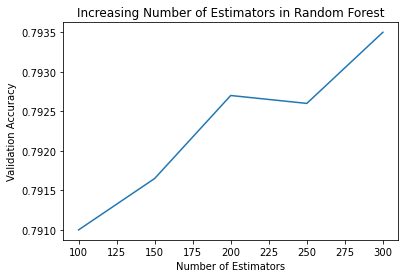

In [38]:
fig, ax = plt.subplots()

plt.plot(np.linspace(100, 300, 5), scores)
ax.set(title='Increasing Number of Estimators in Random Forest',
       ylabel='Validation Accuracy',
       xlabel='Number of Estimators');

Increasing the number of estimators did increase the validation accuracy, but not by much.

In [ ]:
model_scores['rf2'] = {
    'model': clone(rf2)),
    'train': None,
    'test': np.max(scores)
}
model_scores

Let's try decreasing the number of features included at each split, to discourage overfitting. Currently, the model selects about 6% of the total number of features to include at each split.

In [42]:
np.sqrt(vectorized_words3.shape[1]) / vectorized_words3.shape[1]

0.06178020632152155

In [44]:
train_scores=[]
scores=[]

for n in np.linspace(0.01, 0.06, 5):
    rf3 = RandomForestClassifier(max_features=n, random_state=seed)
    rf3.fit(vectorized_words3, train_labels)
    train_scores.append(rf3.score(vectorized_words3, train_labels))
    scores.append(rf2.score(val_vectorized_words3, val_labels))

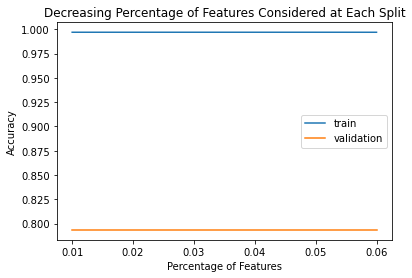

In [45]:
fig, ax = plt.subplots()

plt.plot(np.linspace(0.01, 0.06, 5), train_scores, label='train')
plt.plot(np.linspace(0.01, 0.06, 5), scores, label='validation')
ax.legend()
ax.set(title='Decreasing Percentage of Features Considered at Each Split',
       xlabel='Percentage of Features',
       ylabel='Accuracy');

Decreasing the percentage of features considered at each split had NO effect whatsoever on the model's train OR validation accuracy!

In [ ]:
model_scores['rf3'] = {
    'model': clone(rf3),
    'train': train_scores[np.argmax(scores)],
    'test': np.max(scores)
}
model_scores

Try starting with a low max_depth, then increasing until best accuracy is achieved.

In [49]:
train_scores=[]
scores=[]

for n in [int(x) for x in np.linspace(5, 150, 10)]:
    rf4 = RandomForestClassifier(max_depth=n, random_state=seed)
    rf4.fit(vectorized_words3, train_labels)
    train_scores.append(rf4.score(vectorized_words3, train_labels))
    scores.append(rf4.score(val_vectorized_words3, val_labels))

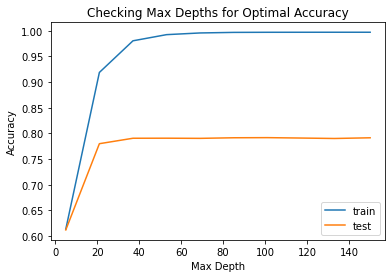

In [50]:
fig, ax = plt.subplots()

plt.plot([int(x) for x in np.linspace(5, 150, 10)], train_scores, label='train')
plt.plot([int(x) for x in np.linspace(5, 150, 10)], scores, label='test')
ax.legend()
ax.set(title='Checking Max Depths for Optimal Accuracy',
       xlabel='Max Depth',
       ylabel='Accuracy');

The model reaches its peak validation accuracy at a maximum depth of 40, where accuracy levels off. We can reduce the model complexity without sacrificing accuracy.

In [52]:
model_scores['rf4'] = {
    'model': RandomForestClassifier(max_depth=40, random_state=seed),
    'train': train_scores[np.argmax(scores)],
    'test': np.max(scores)
}
model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918}}

Our model may just need more data.

As a final attempt to increase the model accuracy, try increasing the minimum number of samples left in each leaf.

In [53]:
train_scores=[]
scores=[]

for n in [int(x) for x in np.linspace(10, 50, 5)]:
    rf5 = RandomForestClassifier(min_samples_leaf=n, n_estimators=40, random_state=seed)
    rf5.fit(vectorized_words3, train_labels)
    train_scores.append(rf5.score(vectorized_words3, train_labels))
    scores.append(rf5.score(val_vectorized_words3, val_labels))

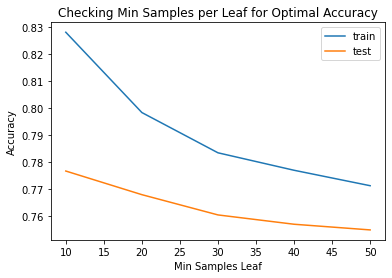

In [54]:
fig, ax = plt.subplots()

plt.plot([int(x) for x in np.linspace(10, 50, 5)], train_scores, label='train')
plt.plot([int(x) for x in np.linspace(10, 50, 5)], scores, label='test')
ax.legend()
ax.set(title='Checking Min Samples per Leaf for Optimal Accuracy',
       xlabel='Min Samples Leaf',
       ylabel='Accuracy');

Increasing the minimum number of samples remaining in each leaf at the end of training decreased both train and validation accuracy.

In [55]:
train_scores=[]
scores=[]

for n in [int(x) for x in np.linspace(1, 10, 10)]:
    rf6 = RandomForestClassifier(min_samples_leaf=n, n_estimators=40, random_state=seed)
    rf6.fit(vectorized_words3, train_labels)
    train_scores.append(rf6.score(vectorized_words3, train_labels))
    scores.append(rf6.score(val_vectorized_words3, val_labels))

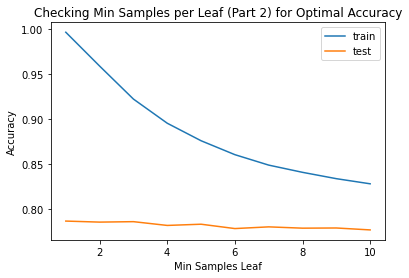

In [56]:
fig, ax = plt.subplots()

plt.plot([int(x) for x in np.linspace(1, 10, 10)], train_scores, label='train')
plt.plot([int(x) for x in np.linspace(1, 10, 10)], scores, label='test')
ax.legend()
ax.set(title='Checking Min Samples per Leaf (Part 2) for Optimal Accuracy',
       xlabel='Min Samples Leaf',
       ylabel='Accuracy');

The default value for min_samples_leaf turns out to be the best.

In [67]:
model_scores['rf6'] = {
    'model': RandomForestClassifier(min_samples_leaf=1, max_depth=40, random_state=seed),
    'train': train_scores[np.argmax(scores)],
    'test': np.max(scores)
}
model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645}}

In [68]:
# takes a long time to run; investigate why

# from skopt import BayesSearchCV

# rf2 = RandomForestClassifier()
# params = {'n_estimators': (50, 300),
#           'max_features': (0.1, 1.0, 'uniform'),
#           'max_depth': (5, 150),
#           'min_samples_leaf': (10, 50)}
# bayes_search = BayesSearchCV(rf2, params, n_iter=10)
# bayes_search.fit(vectorized_words3, train_labels)

Try balancing the class weight.

In [69]:
rf7 = RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=seed)

rf7.fit(vectorized_words3, train_labels)

model_scores['rf7'] = {
    'model': clone(rf7),
    'train': rf7.score(vectorized_words3, train_labels),
    'test': rf7.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894}}

Balancing the class weights actually decreases the performance of the model (compared to rf4.)

I doubt that we can do better with a logistic regression model, but let's fit one to see if we can deliver decent results with a simpler, less memory intensive type of model.

In [70]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=seed)
logreg.fit(vectorized_words3, train_labels)

model_scores['logreg'] = {
    'model': clone(logreg),
    'train': logreg.score(vectorized_words3, train_labels),
    'test': logreg.score(val_vectorized_words3, val_labels)
}

model_scores

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901}}

A vanilla logistic regression performed almost as well as the best random forest so far, and it didn't even converge (nor is it overfit to the training data.)

Try decreasing the regularization strength to see if this caused the failure to converge (and possibly also prevented overfitting.)

In [71]:
logreg2 = LogisticRegression(C=10000, random_state=seed)

logreg2.fit(vectorized_words3, train_labels)

model_scores['logreg2'] = {
    'model': clone(logreg2),
    'train': logreg2.score(vectorized_words3, train_labels),
    'test': logreg2.score(val_vectorized_words3, val_labels)
}

model_scores

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegressio

Interestingly, increasing the regularization strength didn't fix the convergence problem.

Increase the maximum number of iterations performed.

In [72]:
logreg3 = LogisticRegression(max_iter=10000, random_state=seed)

logreg3.fit(vectorized_words3, train_labels)

model_scores['logreg3'] = {
    'model': clone(logreg3),
    'train': logreg3.score(vectorized_words3, train_labels),
    'test': logreg3.score(val_vectorized_words3, val_labels)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegressio

Increasing the number of iterations fixes the lack of convergence problem, and it technically improves performance on the test set, but not by much.

The model is not particularly overfit. Try decreasing regularization to see if the model is underfit.

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
grid = {'C': [1, 10, 100],
        'max_iter': [10000],
        'random_state': [seed]}

logreg4 = LogisticRegression()
grid_search = GridSearchCV(logreg4, grid, scoring='accuracy', return_train_score=True, cv=2)
grid_search.fit(vectorized_words3, train_labels)

model_scores['logreg_grid_search1'] = {
    'model': clone(grid_search.best_estimator_),
    'train': grid_search.cv_results_['mean_train_score'][grid_search.best_index_],
    'test': grid_search.best_score_
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegressio

Decreasing regularization strength caused our model to underfit somehow.

Visualize the best model's performance so far.

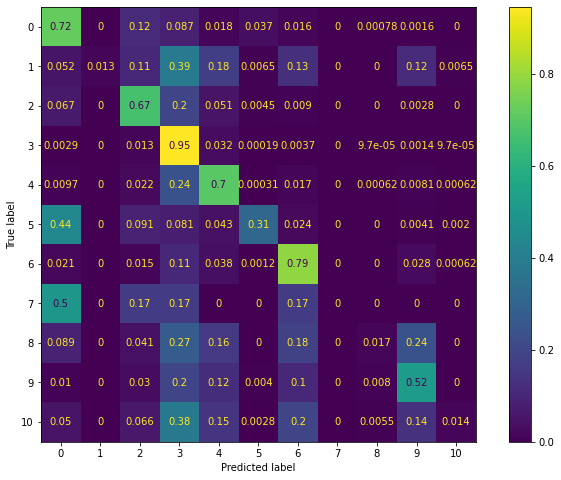

In [81]:
fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(val_labels,
                                        rf4.predict(
                                            val_vectorized_words3),
                                        normalize='true')).plot(ax=ax);

In [85]:
print('The model struggles to classifying the following types of complaints:\n')
[print(le.classes_[i]) for i in [5, 7, 8, 10]]

The model struggles to classifying the following types of complaints:

Money transfer, virtual currency, or money service
Other financial service
Payday loan, title loan, or personal loan
Vehicle loan or lease


[None, None, None, None]

I'm OK with the model struggling with "Other financial service".

Money transfer, virtual currency or money service is mis-classified as Bank account or service 50% of the time.

Try performing PCA before fitting the model.

In [79]:
from sklearn.decomposition import PCA

In [77]:
best_model_so_far = clone(rf4)

In [78]:
vectorized_words3.shape

(60000, 262)

In [80]:
pca = PCA(n_components=131, random_state=seed) # keep half of original number of components
train_transformed = pca.fit_transform(vectorized_words3)
best_model_so_far.fit(train_transformed, train_labels)
model_scores['pca_131'] = {
    'model': clone(best_model_so_far),
    'train': best_model_so_far.score(train_transformed, train_labels),
    'test': best_model_so_far.score(pca.transform(val_vectorized_words3), val_labels)
}
model_scores

In [88]:
model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegressio

Keeping only half of the number of original components didn't perform very well.

Try keeping additional components.

In [91]:
train_scores=[]
scores=[]

for n in [int(x) for x in np.linspace(131, 262, 5)]:
    pca2 = PCA(n_components=n, random_state=seed)
    train_transformed2 = pca2.fit_transform(vectorized_words3)
    best_model_so_far.fit(train_transformed2, train_labels)
    train_scores.append(best_model_so_far.score(train_transformed2, train_labels))
    scores.append(best_model_so_far.score(pca2.transform(val_vectorized_words3), val_labels))

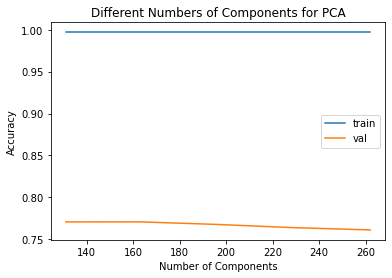

In [92]:
fig, ax = plt.subplots()

plt.plot([int(x) for x in np.linspace(131, 262, 5)], train_scores, label='train')
plt.plot([int(x) for x in np.linspace(131, 262, 5)], scores, label='val')
ax.legend()
ax.set(title='Different Numbers of Components for PCA',
       xlabel='Number of Components',
       ylabel='Accuracy');

In [93]:
model_scores['pca2'] = {
    'model': clone(best_model_so_far),
    'train': train_scores[np.argmax(scores)],
    'test': np.max(scores)
}

model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegressio

First, find the best model so far:

In [94]:
results = pd.DataFrame({'model': list(model_scores.keys()),
                        'train': [model['train'] for model in list(model_scores.values())],
                        'test': [model['test'] for model in list(model_scores.values())]}
            )

In [95]:
results.loc[results.test == results.test.max()]

,model,train,test
5,rf4,0.99695,0.7918


In [97]:
best_model_so_far = model_scores['rf4']['model']

In [101]:
best_model_so_far

RandomForestClassifier(max_depth=40, random_state=839)

In [103]:
big_rf = RandomForestClassifier(n_estimators=300, random_state=seed)
big_rf.fit(vectorized_words3, train_labels)
big_rf.score(vectorized_words3, train_labels)

0.9970333333333333

In [104]:
big_rf.score(val_vectorized_words3, val_labels)

0.7935

In [107]:
model_scores['big_rf'] = {
    'model': clone(big_rf),
    'train': big_rf.score(vectorized_words3, train_labels),
    'test': big_rf.score(val_vectorized_words3, val_labels),
}
model_scores

{'baseline': {'model': MultinomialNB(),
  'train': 0.7224333333333334,
  'test': 0.6991},
 'min_max_df': {'model': MultinomialNB(),
  'train': 0.7403666666666666,
  'test': 0.73935},
 'include_bigrams': {'model': MultinomialNB(), 'train': 0.743, 'test': 0.7445},
 'undersampled': {'model': MultinomialNB(),
  'train': 0.6756054702421881,
  'test': 0.7163},
 'rf': {'model': RandomForestClassifier(random_state=839),
  'train': 0.9970333333333333,
  'test': 0.791},
 'rf4': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.99695,
  'test': 0.7918},
 'rf6': {'model': RandomForestClassifier(max_depth=40, random_state=839),
  'train': 0.9968666666666667,
  'test': 0.78645},
 'rf7': {'model': RandomForestClassifier(class_weight='balanced', max_depth=40, random_state=839),
  'train': 0.9871666666666666,
  'test': 0.7894},
 'logreg': {'model': LogisticRegression(random_state=839),
  'train': 0.7954666666666667,
  'test': 0.7901},
 'logreg2': {'model': LogisticRegressio

In [109]:
results = pd.DataFrame({'model': list(model_scores.keys()),
                        'train': [model['train'] for model in list(model_scores.values())],
                        'test': [model['test'] for model in list(model_scores.values())]}
            )

results

,model,train,test
0,baseline,0.722433,0.699100
1,min_max_df,0.740367,0.739350
2,include_bigrams,0.743000,0.744500
3,undersampled,0.675605,0.716300
4,rf,0.997033,0.791000
5,rf4,0.996950,0.791800
6,rf6,0.996867,0.786450
7,rf7,0.987167,0.789400
8,logreg,0.795467,0.790100
9,logreg2,0.797233,0.789150


## Conclusion

Our best model so far is a random forest with 300 estimators, achieving an accuracy of 79.35% on the validation data. (A random forest with 100 estimators has a similar accuracy - a quarter of a percentage point less - so this solution could be used if time to train / model complexity is an issue.)

In [131]:
best_model = model_scores['big_rf']['model']

Confirm model performance on the test set:

In [124]:
# load test data
X_test = pd.read_csv('data/train-test-split/test')
X_test.set_index('Unnamed: 0', inplace=True)
X_test.index.name = None
X_test.head()

,Complaint,Company,tokens,clean_tokens,lemmas
2766785,Hello I've recently in XX/XX/XXXX attempted to...,Experian Information Solutions Inc.,"['hello', ""'ve"", 'recently', 'xx/xx/xxxx', 'at...","['hello', ""'ve"", 'recently', 'attempted', 'dis...","['hello', ""'ve"", 'recently', 'attempt', 'dispu..."
2173377,"XXXX XXXX XXXX XXXX XXXX XXXX XXXX XXXX, FL XX...","Fidelity National Information Services, Inc. (...","['xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx...","['fl', 'consumer', 'id', 'brought', 'attention...","['fl', 'consumer', 'id', 'bring', 'attention',..."
1967270,Its worth XXXX XXXX XXXX I called them they sa...,"Professional Finance Company, Inc.","['worth', 'xxxx', 'xxxx', 'xxxx', 'called', 's...","['worth', 'called', 'said', 'dont', 'account',...","['worth', 'call', 'say', 'dont', 'account', 'n..."
570871,Greetings I have been patient with the credit ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","['greetings', 'patient', 'credit', 'bureaus', ...","['greetings', 'patient', 'credit', 'bureaus', ...","['greeting', 'patient', 'credit', 'bureau', 'y..."
2807234,XXXX XXXX is making multiple false report to m...,"EQUIFAX, INC.","['xxxx', 'xxxx', 'making', 'multiple', 'false'...","['making', 'multiple', 'false', 'report', 'cre...","['make', 'multiple', 'false', 'report', 'credi..."


In [153]:
y_test = pd.read_csv('data/train-test-split/ytest')
y_test.set_index('Unnamed: 0', inplace=True)
y_test.index.name=None

In [141]:
full_X_train = pd.concat([X_train, X_val], axis=0)
full_y_train = pd.concat([y_train, y_val], axis=0)
full_train_labels = le.fit_transform(full_y_train)

In [151]:
transformed_full_X_train = tfidf_vec_w_bigrams.fit_transform(full_X_train.lemmas)
transformed_full_X_train= pd.DataFrame(transformed_full_X_train.todense(),
                                       columns=tfidf_vec_w_bigrams.vocabulary_,
                                       index=full_X_train.index)
transformed_full_X_train.head(2)

,submit,complaint,inform,third,party,process,send,letter,equifax,credit,...,way,purchase,victim,stop,statement,score,credit score,transfer,online,already
364212,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.078713,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000
2207116,0.0,0.0,0.0,0.053757,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.052912,0.0,0.0,0.03785,0.0,0.0,0.0,0.168291


In [152]:
best_model.fit(transformed_full_X_train, full_train_labels)

RandomForestClassifier(n_estimators=300, random_state=839)

In [154]:
transformed_X_test = tfidf_vec_w_bigrams.transform(X_test.lemmas)
test_labels = le.transform(y_test)

best_model.score(transformed_X_test, test_labels)

/Users/user/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.8012

Our model performs about as well as expected on the test data with an overall accuracy of 80%.

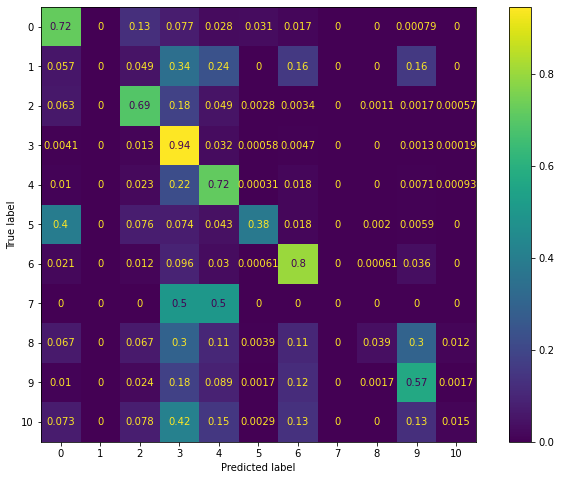

In [162]:
fig, ax = plt.subplots(figsize=(12, 8))

ConfusionMatrixDisplay(confusion_matrix(
    test_labels,
    best_model.predict(transformed_X_test),
    normalize='true'
)
                                       ).plot(ax=ax);

Inspect the accuracy by class:

In [203]:
confusion_matrix_values = confusion_matrix(
    test_labels,
    best_model.predict(transformed_X_test),
    normalize='true'
)

class_accuracies = [confusion_matrix_values[i][i] for i in range(len(le.classes_))]
pd.Series(class_accuracies, index=le.classes_).sort_values(ascending=False)

Credit reporting, credit repair services, or other personal consumer reports    0.944752
Mortgage                                                                        0.804149
Bank account or service                                                         0.719685
Debt collection                                                                 0.716137
Credit card or prepaid card                                                     0.693576
Student loan                                                                    0.568696
Money transfer, virtual currency, or money service                              0.382812
Payday loan, title loan, or personal loan                                       0.039216
Vehicle loan or lease                                                           0.014535
Other financial service                                                         0.000000
Consumer Loan                                                                   0.000000
dtype: float64

Our model does not do as well when classifying loans or money transfers / money services / virtual currency.

This somewhat corresponds with the amount of data we have in each product category. The model has less than 60% accuracy on products with fewer than 5000 complaints in the training data:

In [205]:
full_y_train.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    41042
Debt collection                                                                 12943
Credit card or prepaid card                                                      7081
Mortgage                                                                         6526
Bank account or service                                                          5053
Student loan                                                                     2200
Money transfer, virtual currency, or money service                               1961
Vehicle loan or lease                                                            1453
Payday loan, title loan, or personal loan                                        1138
Consumer Loan                                                                     581
Other financial service                                                            22
Name: Product, dtype: int64

Explain model's decision making process:

In [174]:
feat_importance_dict = dict(zip(tfidf_vec_w_bigrams.vocabulary_,
                                best_model.feature_importances_))

In [190]:
most_important_words = sorted(feat_importance_dict.items(), key=lambda x: x[1], reverse=True)

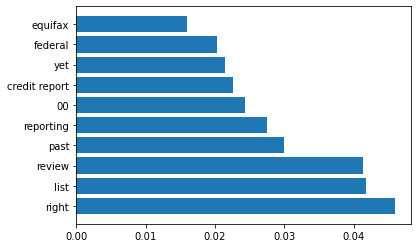

In [195]:
labels = [tuple[0] for tuple in most_important_words[:10]]
importances = [feat_importance_dict[key] for key in labels]

fig, ax = plt.subplots()

plt.sca(ax)
plt.barh(y=np.linspace(1,10,10), width=importances)
ax.set_yticks(np.linspace(1,10,10))
ax.set_yticklabels(labels);

There are some expected words, like "equifax", "federal", "credit report" and "reporting" that show up in the feature importances of our model; **however, some odd words like "yet" and "right", which don't seem to be particularly descriptive of a particular product category**, and the numerical object "00" also show up as important factors in the model's decision.

This is worth exploring further - do these really have a stronger correlation with certain product categories? If so, why? If not, how can we preprocess our text further to force the model to focus on more relevant information?

## Next Steps

Explore preprocessing and training techniques to allow the model to better classify under-represented product categories (including removing additional "stop words" and "numerical objects" from the lemmas included in the model.)